## Training code for MoDL

In [1]:
import os, torch, time
import json
from torch import optim
import numpy as np
import torch.nn as nn
import torch.autograd as autograd

from tqdm import tqdm
from datetime import datetime
from scipy.io import savemat
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

from mri import sense
from solvers import *
from data_builder import preload, preprocess

import matplotlib.pyplot as plt
from misc import *
device = torch.device("cuda")

#### Load training settings

In [2]:
ts = TrainSettings("modl_settings.json")

# update dict of global variables with settings, poor practice but very convenient
globals().update(ts.__dict__)

timestamp = datetime.now()
save_dir = models_dir + timestamp.strftime("%b%d_%H%M") + f'_{num_sub}sub_{num_sl}sl_{net_type}'

print(f"Saving to {save_dir}")

log_every_N_epochs = 1
save_model_every_N_epochs = training_epochs // 5
ts.save_model_every_N_epochs, ts.log_every_N_epochs = save_model_every_N_epochs, log_every_N_epochs

if not(os.path.exists(save_dir)):
    os.makedirs(save_dir)
    
log_fname = save_dir + "/log.txt"

writeLog('\n'+'*'*40, log_fname)
writeLog(f'Training started on {timestamp.strftime("%d-%b-%Y at %I:%M %P")}', log_fname)
writeLog(f'{save_dir}\n', log_fname)

Settings loaded from modl_settings.json
Saving to models/Mar20_2054_1sub_20sl_modl

****************************************
Training started on 20-Mar-2024 at 08:54 pm
models/Mar20_2054_1sub_20sl_modl



#### Setup before training

In [3]:
A_init = sense(cgIter_init).to(device)
A = sense(cgIter_itr).to(device)

optBlock = modlBlock(A, lam_itr, input_channels, number_of_feature_filters, output_channels, number_of_layers)

model = Unroll(optBlock, K, A_init, lam_init)
model = model.to(device)

if restore:
    model.load_state_dict(torch.load(os.path.join(restore_dir, restore_model))['state_dict'])

loss_function = nn.MSELoss()

optimizer = optim.Adam([
            {'params': model.f.dw.parameters(), 'lr': learning_rate},
            {'params': model.f.lam, 'lr': learning_rate_lam}
        ])
    
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.3)

ts.write_json(save_dir + '/settings.json')

best_training_loss = float("inf")
training_loss_epochs, ploss_epochs, closs_epochs = [], [], []
err_epochs, nFE_epochs, psnr_epochs = [], [], []

Settings saved to models/Mar20_2054_1sub_20sl_modl/settings.json


#### Load dataset

In [4]:
org_data, csm_data, mask_data = preload(data_path, num_sub, num_sl, start_sub, start_sl, acc)
org_data, us_data, csm_data, mask_data = preprocess(org_data, csm_data, mask_data)

num_slices = org_data.shape[0]
writeLog(f"Loaded {num_slices} slices", log_fname)

Loading subjects... 1 
Loading masks...
Preprocessing...
Data builder completed

Loaded 20 slices


### Training Loop

In [5]:
train_start_time = time.time()
with tqdm(total= training_epochs, position=0, leave=True) as pbar:
    for epoch in range(0,training_epochs+1):       
        model.train()
        
        indices = np.random.permutation(num_slices)
        
        training_loss_ep = ploss_ep = closs_ep = 0
        steps_ep = psnr_ep = err_ep = nFE_ep = 0.
        
        epoch_start_time = time.time()
        
        for i in indices:
            
            steps_ep = steps_ep + 1
            
            target_fully_sampled = org_data[i:i+1].to(device)
            target_fully_sampled = torch.abs(target_fully_sampled)
            coil_sensitivity_maps = csm_data[i:i+1].to(device)
            input_under_sampled = us_data[i:i+1].to(device)
            mask = mask_data[i:i+1].to(device)
            
            if epoch==1 and i==indices[0]: mem1 = torch.cuda.memory_allocated()
                
            predicted_fully_sampled, sense_out, err, nFE  = model(input_under_sampled, coil_sensitivity_maps, mask)
            
            if epoch==1 and i==indices[0]: writeLog(f"[after forward pass] -- {(torch.cuda.memory_allocated()-mem1)*1e-9:.3f} GB", log_fname)
            
            predicted_fully_sampled = torch.abs(predicted_fully_sampled)
            
            mse_loss = loss_function(predicted_fully_sampled, target_fully_sampled)
        
            loss = mse_loss
            
            if epoch==1 and i==indices[0]: 
                backprop_start_time = time.time()
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if epoch==1 and i==indices[0]: writeLog(f"[after optimizer step] -- {(torch.cuda.memory_allocated()-mem1)*1e-9:.3f} GB\n", log_fname)
                
            training_loss_ep += loss.detach().cpu().item()
            ploss_ep += mse_loss.detach().cpu().item()
            
            err_ep += err.detach().cpu().item()
            nFE_ep += nFE
            
            prediction = np.squeeze(torch.abs(predicted_fully_sampled).detach().cpu().numpy())
            target = np.squeeze(target_fully_sampled.detach().cpu().numpy())
            psnr_ep += peak_signal_noise_ratio(target, prediction, data_range=target.max())    
            
            torch.cuda.empty_cache()
            
        epoch_end_time = time.time()
        
        training_loss_epochs.append(training_loss_ep)
        ploss_epochs.append(ploss_ep)
        
        err_epochs.append(err_ep/steps_ep)
        nFE_epochs.append(nFE_ep/steps_ep)
        psnr_epochs.append(psnr_ep/steps_ep)
        
        if (epoch % log_every_N_epochs == 0):
            summary = '[Epoch %d] \ttotal-loss: %.6f, pred-loss: %.6f, err: %.5f, λ: %.3f, nFE %d, psnr: %.2f, epoch time: %.2f mins' % (epoch, training_loss_epochs[-1], ploss_epochs[-1], err_epochs[-1], optBlock.lam.detach().cpu().numpy(), nFE_epochs[-1], psnr_epochs[-1], (epoch_end_time - epoch_start_time)/60)
            pbar.set_description(summary)
            pbar.update(log_every_N_epochs)
            writeLog(summary+"\n", log_fname, mute=True)
            
        if np.remainder(epoch, save_model_every_N_epochs)==0:
            save_checkpoint(
                {
                    'epoch': epoch,
                    'state_dict': model.state_dict()
                },
                path=save_dir,
                filename='model.pth.tar'.format(epoch)
            )
     
    pbar.close()
    
train_end_time = time.time()    
writeLog(f"\nTotal time: {round((train_end_time - train_start_time)/60, 2)} mins", log_fname)
writeLog(f"Training completed at {datetime.now().strftime('%d-%b-%Y %I:%M %P')}", log_fname)
writeLog('*'*40, log_fname)

[Epoch 0] 	total-loss: 0.051575, pred-loss: 0.051575, err: 0.00965, λ: 9.803, nFE 10, psnr: 27.82, epoch time: 0.13 mins:   3%|▎         | 1/30 [00:07<03:47,  7.83s/it]

[after forward pass] -- 1.264 GB
[after optimizer step] -- 0.000 GB



[Epoch 30] 	total-loss: 0.005520, pred-loss: 0.005520, err: 0.00218, λ: 7.687, nFE 10, psnr: 35.82, epoch time: 0.11 mins: : 31it [03:25,  6.62s/it]                      


Total time: 3.42 mins
Training completed at 20-Mar-2024 08:58 pm
****************************************


#### Plot training metrics

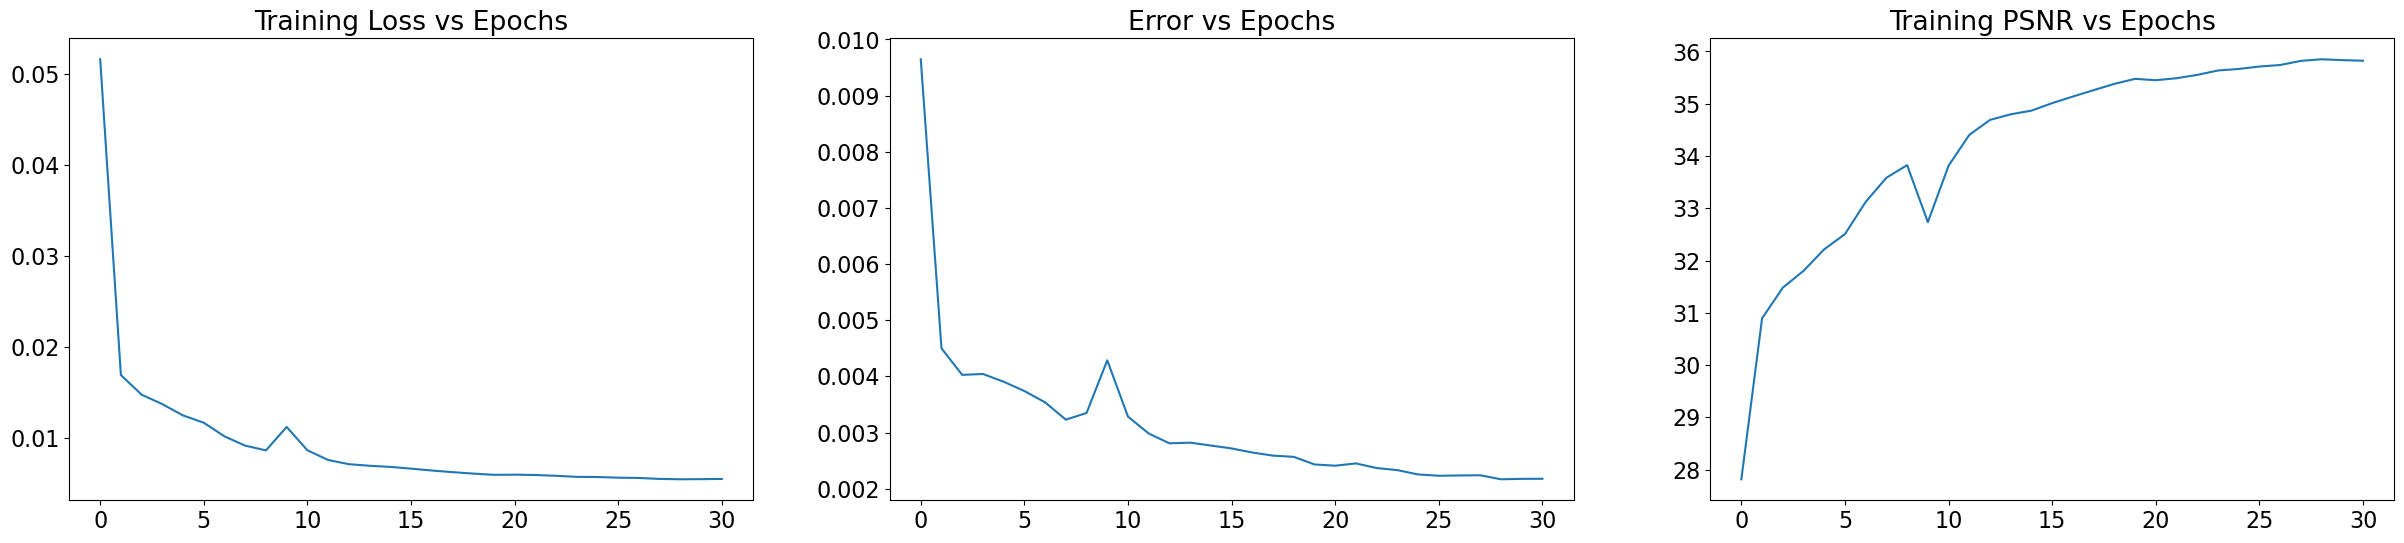

In [6]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, 3, figsize=(30, 6))
ax[0].plot(training_loss_epochs)
ax[0].set_title('Training Loss vs Epochs')
ax[1].plot(err_epochs)
ax[1].set_title('Error vs Epochs')
ax[2].plot(psnr_epochs)
ax[2].set_title('Training PSNR vs Epochs')

plt.savefig(save_dir+'/train_plots.png')

#### Inference on the training data

In [7]:
targets, preds, sense_preds, error_imgs = [], [], [], []
psnr_ins, psnr_outs, ssim_ins, ssim_outs = [], [], [], []

for i in range(num_slices):
    with torch.no_grad():
        target_fully_sampled, coil_sensitivity_maps, input_under_sampled, mask = org_data[i:i+1].to(device), csm_data[i:i+1].to(device), us_data[i:i+1].to(device), mask_data[i:i+1].to(device)
        target_fully_sampled = torch.abs(target_fully_sampled)
    
        predicted_fully_sampled, predicted_sense, err, nFE  = model(input_under_sampled, coil_sensitivity_maps, mask)
    
        prediction = np.squeeze(torch.abs(predicted_fully_sampled).detach().cpu().numpy())
        target = np.squeeze(target_fully_sampled.detach().cpu().numpy())
        inputs = np.squeeze(torch.abs(input_under_sampled).detach().cpu().numpy())
        prediction_sense = np.squeeze(torch.abs(predicted_sense).detach().cpu().numpy())
        err = err.detach().cpu().item()
    
        torch.cuda.empty_cache()
        
        psnri = peak_signal_noise_ratio(target, prediction_sense, data_range=target.max()) 
        psnrf = peak_signal_noise_ratio(target, prediction, data_range=target.max()) 
        
        ssimi = structural_similarity(target, prediction_sense)
        ssimf = structural_similarity(target, prediction)
        
        error_img = np.abs(target - prediction)
        targets.append(target)
        preds.append(prediction)
        sense_preds.append(prediction_sense)
        error_imgs.append(error_img)
        psnr_ins.append(psnri)
        psnr_outs.append(psnrf)
        ssim_ins.append(ssimi)
        ssim_outs.append(ssimf)

In [8]:
writeLog(f'nFE: {nFE}', log_fname)
writeLog(f'error: {err:.6f}', log_fname)
writeLog(f'SENSE PSNR:  {np.mean(psnr_ins):.3f} dB', log_fname)
writeLog(f'MODL PSNR:   {np.mean(psnr_outs):.3f} dB', log_fname)
writeLog(f'SENSE SSIM:  {np.mean(ssim_ins):.3f}', log_fname)
writeLog(f'MODL SSIM:   {np.mean(ssim_outs):.3f}', log_fname)

nFE: 10
error: 0.002634
SENSE PSNR:  31.795 dB
MODL PSNR:   35.896 dB
SENSE SSIM:  0.906
MODL SSIM:   0.962


#### Display reconstructions

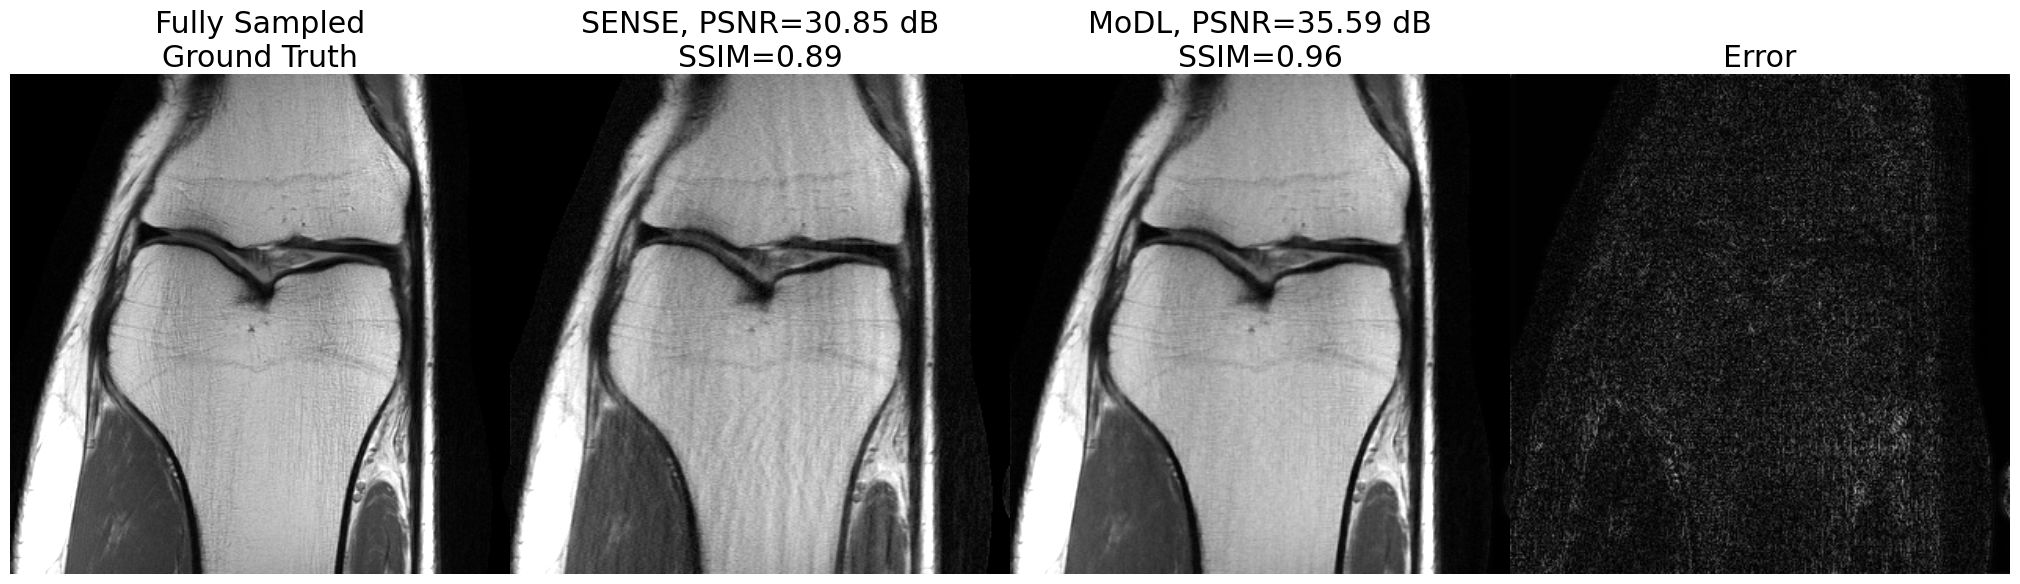

In [9]:
index = 10
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(1, 4, figsize=(20, 10))
def plot(x, i, title="", err=False): 
    if err: 
        ax[i].imshow(x,interpolation='bilinear', cmap=plt.cm.gray, vmax=0.15)
    else:   
        ax[i].imshow(x,interpolation='bilinear',cmap=plt.cm.gray, vmax=0.7)
    ax[i].axis('off')
    ax[i].set_title(title)
    
stco, endco = 0, -1
stro, endro = 0, -1

plot(targets[index][stco:endco,stro:endro], 0, 'Fully Sampled\nGround Truth')

plot(sense_preds[index][stco:endco,stro:endro], 1, f'SENSE, PSNR={psnr_ins[index]:.2f} dB\nSSIM={ssim_ins[index]:.2f}')

plot(preds[index][stco:endco,stro:endro], 2, f'MoDL, PSNR={psnr_outs[index]:.2f} dB\nSSIM={ssim_outs[index]:.2f}')

plot(error_imgs[index][stco:endco,stro:endro], 3, 'Error', err=True)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.)
plt.savefig(save_dir+f'/train_inference_{index}.png')
plt.show()